In [1]:
import numpy as np
import scipy.stats as sps
import scipy.optimize as spo

import matplotlib.pyplot as plt

Случайный датасет. Точки, лежащие на прямой $y = 0.5x + 2$ с нормально распределённой случайной ошибкой с $\sigma=0.5$.

In [2]:
A = 0.5
B = 2.0
n = 100

x = np.linspace(0,10, n)
y = A*x + B + np.random.normal(scale=.5, size=n)

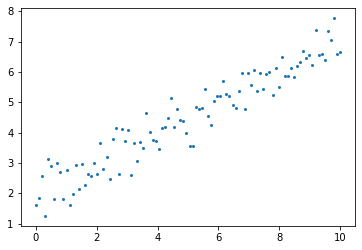

In [3]:
plt.scatter(x,y, s=4)

In [4]:
def mk_model(a,b):
    return lambda x: a*x+b

# Линейная регрессия средствами `linregress`

In [5]:
n = len(x)
lin_model = sps.linregress(x, y)
a,b = lin_model.slope, lin_model.intercept
a_err, b_err = lin_model.stderr, lin_model.intercept_stderr
a_conf = sps.t.interval(0.95, df = n-2, loc=a, scale=a_err)
b_conf = sps.t.interval(0.95, df = n-2, loc=b, scale=b_err)

In [6]:
print(f"a = {a:0.4f} ± {a_err:0.4f}, доверительный интервал α=5% [{a_conf[0]:0.4f} - {a_conf[1]:0.4f}]")
print(f"b = {b:0.4f} ± {b_err:0.4f}, доверительный интервал α=5% [{b_conf[0]:0.4f} - {b_conf[1]:0.4f}]")

a = 0.5098 ± 0.0162, доверительный интервал α=5% [0.4776 - 0.5420]
b = 1.9294 ± 0.0939, доверительный интервал α=5% [1.7430 - 2.1158]


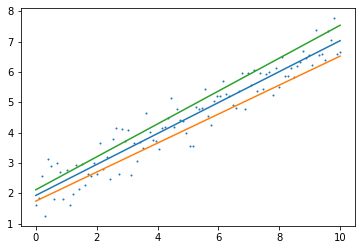

In [7]:
plt.scatter(x, y, s=1)
plt.plot(x, mk_model(a,b)(x))
plt.plot(x, mk_model(a_conf[0], b_conf[0])(x))
plt.plot(x, mk_model(a_conf[1], b_conf[1])(x))

# Использование `curve_fit`
Линейная модель $y = ax+b$

In [8]:
def linear(x, a,b):
    return a*x+b

Подбор параметров линейной модели методом наименьших квадратов

In [9]:
((a,b), cov) = spo.curve_fit(linear, xdata=x, ydata=y)
a_err, b_err = np.sqrt(np.diag(cov))
a_conf = sps.t.interval(0.95, df = n-2, loc=a, scale=a_err)
b_conf = sps.t.interval(0.95, df = n-2, loc=b, scale=b_err)

In [10]:
print(f"a = {a:0.4f} ± {a_err:0.4f}, доверительный интервал α=5% [{a_conf[0]:0.4f} - {a_conf[1]:0.4f}]")
print(f"b = {b:0.4f} ± {b_err:0.4f}, доверительный интервал α=5% [{b_conf[0]:0.4f} - {b_conf[1]:0.4f}]")

a = 0.5098 ± 0.0162, доверительный интервал α=5% [0.4776 - 0.5420]
b = 1.9294 ± 0.0939, доверительный интервал α=5% [1.7430 - 2.1158]


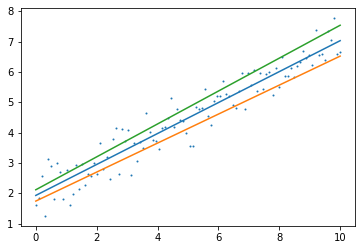

In [11]:
plt.scatter(x, y, s=1)
plt.plot(x, mk_model(a,b)(x))
plt.plot(x, mk_model(a_conf[0], b_conf[0])(x))
plt.plot(x, mk_model(a_conf[1], b_conf[1])(x))

# Прямое вычисление

Случайная составляющая

In [12]:
u = y - (a*x+b)

In [13]:
u_mean, u_sigma = sps.norm.fit(u)
u_mean, u_sigma

(4.372593398471736e-10, 0.4684348355640454)

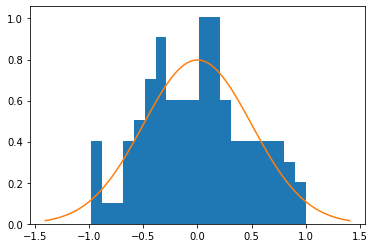

In [14]:
_u = np.linspace(u_mean - u_sigma*3, u_mean + u_sigma*3, 100)
plt.hist(u, bins=20, density=True)

plt.plot(_u, sps.norm(0, 0.5).pdf(_u))

Несмещенная оценка дисперсии случайного члена $u$ $\sigma_u^2 = \frac{1}{n-2}\sum({u_i^2 - \overline{u}^2})$

In [15]:
u_avg = np.mean(u)
sigma_square = 1.0/(n-2)*np.sum((u - u_avg)**2)
sigma_square, sigma_square-u_sigma**2

(0.22390938282644313, 0.004478187656528854)

 $nD[x] = \sum (x-\overline{x})^2$

In [16]:
x_mean = np.mean(x)
dx_square = np.sum((x-x_mean)**2)

Дисперсия $a$: $D[a] = \frac{1}{n}\frac{\sigma_u^2}{D[x]}$

In [17]:
var_a = sigma_square/dx_square

Дисперсия $b$: $D[b] = \sigma_u^2\large[\frac{1}{n} + \frac{\overline{x}^2}{nD[x]}]$

In [18]:
var_b = sigma_square*(1.0/n + np.mean(x)**2/dx_square)

In [19]:
var_a, var_b

(0.0002633706403938757, 0.008823359838111323)

Доверительный интервал для $a$ через $t$ распределение Стьюдента с уровнем значимости $\alpha = 0.05$

In [20]:
conf_a = sps.t.interval(0.95, df = n-2, loc=a, scale=np.sqrt(var_a))
conf_a

(0.4776220616621198, 0.5420327078774922)

Доверительный интервал для $b$ через $t$ распределение Стьюдента с уровнем значимости $\alpha = 0.05$

In [21]:
conf_b = sps.t.interval(0.95, df = n-2, loc = b, scale = np.sqrt(var_b))
conf_b

(1.742979644045528, 2.115792579018616)

График линейных моделей, соответствующих крайним точкам доверительных интервалов

In [22]:
def mk_model(a,b):
    return lambda x: linear(x, a,b)

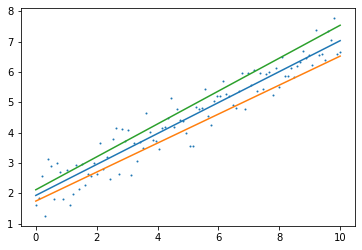

In [23]:
plt.scatter(x, y, s=1)
plt.plot(x, mk_model(a,b)(x))
plt.plot(x, mk_model(conf_a[0], conf_b[0])(x))
plt.plot(x, mk_model(conf_a[1], conf_b[1])(x))

_всякое разное_

In [24]:
np.diag(cov)/np.array((var_a, var_b)) - 1

array([1.33076539e-08, 7.52188223e-09])

In [25]:
sps.t.ppf(0.25, len(x)-2)*b_err

-0.06359260106729048

In [26]:
(conf_b[1] - conf_b[0])/2

0.186406467486544

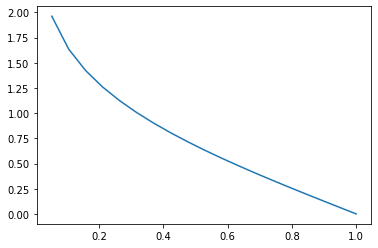

In [27]:
alpha = np.linspace(0,1,20)
plt.plot(alpha, np.abs(sps.t.ppf(alpha/2, n-2)))